# Q. What to Do with Multimodal Data (HAADF + EDX)

## **Given**

* **HAADF image:**
  `haadf` → `np.array` of shape `(512, 512)`
* **Pixel positions:**
  `pixel_pos = [(x₁, y₁), (x₂, y₂), (x₃, y₃), ...]`
* **EDX spectra:**
  Each position `(xₙ, yₙ)` has an associated **2048-dimensional spectrum** (e.g., counts vs. energy).


1. **Build the data matrix:**
   Combine all spectra into an array of shape `(n, 2048)`.

2. **Dimensionality reduction (PCA):**

   * Apply PCA to reduce:

     ```
     (n, 2048) → (n, k)
     ```

     where `k ∈ {1, 2, 3}` depending on visualization needs.
   * Example:

     * `k = 1` → single score per spectrum (scalar intensity)
     * `k = 2 or 3` → scatter visualization in PCA space

3. **Visualization:**

   * **PCA score plots:**
     Plot the reduced components `(PC1, PC2, PC3)` to inspect clusters.
   * **Spatial overlay:**

     * Plot `pixel_pos` over the HAADF image.
     * Color each point by its **first PCA score (PC1)** to visualize spatial variation in spectral features.

   ```python
   plt.imshow(haadf, cmap='gray')
   plt.scatter(x, y, c=pca_scores[:, 0], cmap='viridis', s=10)
   plt.title("HAADF + PCA(EDX) Overlay")
   plt.colorbar(label="PC1 Score")
   plt.show()
   ```


**(Optional Enhancements)**

*  Use **clustering** (e.g., KMeans, GMM) on PCA scores to estimate the number of distinct spectrum types.
*  Visualize **cluster maps** to correlate spectral regions with physical structures in the HAADF image.
*  If needed, normalize spectra before PCA:

  ```python
  spectrum = (spectrum - np.min(spectrum)) / np.ptp(spectrum)
  ```
*  Store results as:

  * `pca_scores.npy`
  * `cluster_labels.npy`
  * `overlay_plot.png`



## 1. Dummy workflow
- Simulated multimodal dataset (HAADF + EDX) with PCA, clustering, and overlays
- Generates a synthetic HAADF image (512x512)
- Samples N random pixel positions
- Simulates a 2048-dim EDX spectrum at each position for 3 "phases"
- Runs PCA and KMeans on spectra
- Plots: HAADF + PCA(PC1) overlay, PCA scatter with clusters
- Saves: pca_scores.npy, cluster_labels.npy, overlay_plot.png, pca_scatter.png

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

rng = np.random.default_rng(42)

In [ ]:
# -----------------------------
# 1) Simulate a HAADF image
# -----------------------------
H, W = 512, 512


# Create 3 smooth "domains" via Gaussian blobs
def gaussian_2d(x, y, cx, cy, sx, sy):
    return np.exp(-(((x - cx) ** 2) / (2 * sx**2) + ((y - cy) ** 2) / (2 * sy**2)))


yy, xx = np.mgrid[0:H, 0:W]
blob1 = 0.9 * gaussian_2d(xx, yy, 150, 170, 90, 120)
blob2 = 0.7 * gaussian_2d(xx, yy, 360, 320, 80, 80)
blob3 = 0.5 * gaussian_2d(xx, yy, 260, 120, 60, 50)

haadf = blob1 + blob2 + blob3
haadf += 0.08 * rng.normal(size=(H, W))
haadf = np.clip(haadf, 0, None)
haadf /= haadf.max()

plt.imshow(haadf)

In [ ]:
# -----------------------------
# 2) Sample pixel positions
# -----------------------------
N = 30  # keep this modest to stay fast
xs = rng.integers(0, W, size=N)
ys = rng.integers(0, H, size=N)
pixel_pos = np.stack([xs, ys], axis=1)

print("number of position", N)

In [ ]:
# -----------------------------
# 3) Simulate 3-phase EDX spectra
# -----------------------------
num_channels = 2048
channels = np.linspace(0, 20.0, num_channels)  # e.g., keV axis (0-20 keV)


def make_phase_template(peaks_keV, widths, amplitudes):
    """Create a spectral template with multiple Gaussian peaks."""
    spec = np.zeros_like(channels)
    for mu, w, a in zip(peaks_keV, widths, amplitudes):
        spec += a * np.exp(-0.5 * ((channels - mu) / w) ** 2)
    # Add a mild background
    spec += 0.02 + 0.02 * (channels / channels.max())
    return spec

In [ ]:
# Define 3 "phases" with different peak patterns
template_A = make_phase_template(
    peaks_keV=[2.2, 5.0, 8.6], widths=[0.12, 0.18, 0.22], amplitudes=[1.0, 0.7, 0.9]
)
template_B = make_phase_template(
    peaks_keV=[1.0, 6.4, 9.7, 12.0],
    widths=[0.15, 0.20, 0.18, 0.25],
    amplitudes=[0.8, 1.0, 0.6, 0.7],
)
template_C = make_phase_template(
    peaks_keV=[3.5, 7.2, 15.0], widths=[0.16, 0.22, 0.30], amplitudes=[0.9, 0.8, 0.9]
)

templates = np.stack([template_A, template_B, template_C], axis=0)
templates.shape

In [ ]:
# Map position -> phase probability using the HAADF intensity + location
# (just a heuristic to produce structured spatial phase regions)
norm_h = haadf[ys, xs]
pA = 0.6 * norm_h + 0.2 * (xs / W) + 0.2 * (1 - ys / H)
pB = 0.5 * (1 - norm_h) + 0.3 * (ys / H) + 0.2 * (xs / W)
pC = 1.0 - (pA + pB)

# Stabilize & normalize
stack = np.stack([pA, pB, pC], axis=1)
stack = np.maximum(stack, 1e-4)
stack = stack / stack.sum(axis=1, keepdims=True)

In [ ]:
# Draw a hard phase label per pixel
phase_labels_true = np.array([rng.choice(3, p=stack[i]) for i in range(N)])

In [ ]:
# Generate spectra with count scaling and noise
def simulate_spectrum(phase_idx, count_scale):
    base = templates[phase_idx]
    # scale counts (like dwell time / thickness effects)
    spec = count_scale * base
    # Poisson-like noise (approximate)
    noisy = rng.poisson(lam=np.clip(spec * 200.0, 1e-3, None)).astype(
        float
    )  # scale up, then noise
    noisy /= 200.0
    # slight baseline drift
    drift = 1.0 + 0.05 * rng.normal()
    return np.clip(noisy * drift, 0, None)

In [ ]:
spectra = np.empty((N, num_channels), dtype=np.float32)
for i in range(N):
    phase = phase_labels_true[i]
    # vary scale by local HAADF intensity
    scale = 0.8 + 0.6 * norm_h[i]
    spectra[i] = simulate_spectrum(phase, scale)

spectra.shape

In [ ]:
# Optional: normalize spectra (safe min-max per spectrum)
mins = spectra.min(axis=1, keepdims=True)
ptps = np.ptp(spectra, axis=1, keepdims=True)
ptps = np.where(ptps == 0, 1.0, ptps)
spectra_norm = (spectra - mins) / ptps

In [ ]:
# -----------------------------
# 4) PCA and KMeans
# -----------------------------
k = 3
pca = PCA(n_components=k, random_state=42)
scores = pca.fit_transform(spectra_norm)  # shape (N, k)

In [ ]:
# KMeans on PCA scores
km = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_labels = km.fit_predict(scores)

In [ ]:
# -----------------------------
# 5) Plots
# -----------------------------

# a) HAADF overlay with PC1 color
plt.figure(figsize=(6, 6))
plt.imshow(haadf)
plt.scatter(xs, ys, c=scores[:, 0], s=6)
plt.title("HAADF + EDX PCA Overlay (PC1 color)")
plt.colorbar(label="PC1 score")
plt.tight_layout()
# plt.savefig("/mnt/data/overlay_plot.png", dpi=160)
plt.show()

In [ ]:
# b) PCA scatter with clusters
plt.figure(figsize=(6, 5))
plt.scatter(scores[:, 0], scores[:, 1], s=8, alpha=0.8, c=cluster_labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter of EDX Spectra with KMeans Clusters")
plt.tight_layout()
# plt.savefig("/mnt/data/pca_scatter.png", dpi=160)
plt.show()

In [ ]:
# -----------------------------
# 6) Save artifacts
# -----------------------------
# np.save("/mnt/data/pca_scores.npy", scores)
# np.save("/mnt/data/cluster_labels.npy", cluster_labels)
# np.save("/mnt/data/pixel_pos.npy", pixel_pos)
# np.save("/mnt/data/haadf.npy", haadf)
# np.save("/mnt/data/spectra_norm.npy", spectra_norm)

## 2. Dummy workflow 2 with random arrays

In [ ]:
H, W = 512, 512

# get haadf- a random numpy array of size 512*512
haadf = np.random.random(size=(H, W))
plt.imshow(haadf)

In [ ]:
# Show the HAADF image

import pandas as pd
from skimage import exposure

plt.figure(figsize=(6, 6))
plt.imshow(haadf)
plt.title("Synthetic HAADF (512x512)")
plt.tight_layout()
# plt.savefig("/mnt/data/haadf.png", dpi=160)
plt.show()


# -----------------------------
# b) Plot pixel distribution
# -----------------------------
def plot_hist(arr, title):
    arr_flat = arr.ravel()
    plt.figure(figsize=(6, 4))
    plt.hist(arr_flat, bins=100)
    plt.title(title)
    plt.xlabel("Pixel value")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


plot_hist(haadf, "Histogram: Original HAADF")


# -----------------------------
# c) Normalizations
# -----------------------------
def safe_minmax(a):
    a = a.astype(float)
    mn = np.nanmin(a)
    ptp = np.ptp(a)
    ptp = ptp if ptp != 0 else 1.0
    return (a - mn) / ptp


def zscore_rescaled(a):
    a = a.astype(float)
    mu = np.nanmean(a)
    sd = np.nanstd(a)
    sd = sd if sd != 0 else 1.0
    z = (a - mu) / sd
    return safe_minmax(z)


def robust_zscore_rescaled(a):
    a = a.astype(float)
    med = np.nanmedian(a)
    mad = np.nanmedian(np.abs(a - med))
    scale = 1.4826 * mad if mad != 0 else 1.0
    z = (a - med) / scale
    return safe_minmax(z)


def percentile_minmax(a, lo=1, hi=99):
    a = a.astype(float)
    p1, p99 = np.nanpercentile(a, [lo, hi])
    denom = max(p99 - p1, 1e-9)
    return np.clip((a - p1) / denom, 0, 1)


def hist_equalize(a):
    a = safe_minmax(a)
    return exposure.equalize_hist(a)


def clahe(a, clip=0.01):
    a = safe_minmax(a)
    return exposure.equalize_adapthist(a, clip_limit=clip)


def background_subtract(a, sigma=20):
    a = a.astype(float)
    bg = ndi.gaussian_filter(a, sigma=sigma)
    res = a - bg
    return safe_minmax(res)


def log_compress(a, gain=5.0):
    a = safe_minmax(a)
    return np.log1p(gain * a) / np.log1p(gain)


def gamma_correct(a, gamma=0.6):
    a = safe_minmax(a)
    return np.power(a, gamma)


def lcn(a, size=15):
    a = a.astype(float)
    mu = ndi.uniform_filter(a, size=size)
    sd = np.sqrt(ndi.uniform_filter((a - mu) ** 2, size=size)) + 1e-6
    z = (a - mu) / sd
    return safe_minmax(z)


# Simulate a flat-field (gain) pattern and correct
def flat_field_correct(a):
    a = a.astype(float)
    # synthetic spatial sensitivity
    yy, xx = np.mgrid[0 : a.shape[0], 0 : a.shape[1]]
    sens = 0.8 + 0.2 * (np.sin(xx / 40.0) * np.cos(yy / 50.0))
    dark = 0.02  # small offset
    corrected = (a - dark) / np.maximum(sens, 1e-6)
    return safe_minmax(corrected)


normalizations = {
    "minmax": safe_minmax,
    "zscore_rescaled": zscore_rescaled,
    "robust_zscore_rescaled": robust_zscore_rescaled,
    "percentile_minmax_1_99": lambda a: percentile_minmax(a, 1, 99),
    "hist_equalize": hist_equalize,
    "clahe": clahe,
    "background_subtract_sigma20": background_subtract,
    "log_compress_gain5": log_compress,
    "gamma_0.6": gamma_correct,
    "lcn_size15": lcn,
    "flat_field_correct": flat_field_correct,
}

results = {}
# out_dir = Path("/mnt/data")
# out_dir.mkdir(parents=True, exist_ok=True)

# Apply each normalization, plot histogram and save normalized image
for name, func in normalizations.items():
    try:
        arr = func(haadf)
        arr = np.nan_to_num(arr, nan=0.0, posinf=1.0, neginf=0.0)
        arr = np.clip(arr, 0, 1)  # ensure comparable domain
        results[name] = arr

        # Save image
        plt.figure(figsize=(6, 6))
        plt.imshow(arr)
        plt.title(f"Normalized: {name}")
        plt.tight_layout()
        # plt.savefig(str(out_dir / f"norm_{name}.png"), dpi=160)
        plt.show()

        # Plot histogram
        plot_hist(arr, f"Histogram: {name}")
    except Exception as e:
        # record failure
        results[name] = None
        print(f"[WARN] {name} failed with error: {e}")


# -----------------------------
# d) Score and choose best-distributed
# -----------------------------
def histogram_entropy(a, bins=256):
    h, edges = np.histogram(a.ravel(), bins=bins, range=(0, 1), density=True)
    h = h + 1e-12  # avoid log(0)
    p = h / h.sum()
    return -np.sum(p * np.log(p))


def spread_score(a):
    # Combined score: entropy + normalized std
    ent = histogram_entropy(a, bins=256)
    std = float(np.std(a))
    return ent + std, ent, std


rows = []
for name, arr in results.items():
    if arr is None:
        rows.append((name, np.nan, np.nan, np.nan))
    else:
        total, ent, std = spread_score(arr)
        rows.append((name, total, ent, std))

df = pd.DataFrame(rows, columns=["method", "score_total(ent+std)", "entropy", "std"])
df_sorted = df.sort_values("score_total(ent+std)", ascending=False).reset_index(
    drop=True
)

# Save scores
# score_csv = out_dir / "normalization_scores.csv"
# df_sorted.to_csv(score_csv, index=False)

# Display top-5 in console
print("Top 5 normalization methods by spread score:")
print(df_sorted.head(5).to_string(index=False))

# Save best image and histogram
best_method = df_sorted.iloc[0]["method"]
best_img = results[best_method]
plt.figure(figsize=(6, 6))
plt.imshow(best_img)
plt.title(f"BEST distributed normalization: {best_method}")
plt.tight_layout()
# plt.savefig(str(out_dir / f"best_{best_method}.png"), dpi=160)
plt.show()

plot_hist(best_img, f"Histogram: BEST = {best_method}")

# # Show the table to the user
# from caas_jupyter_tools import display_dataframe_to_user
# display_dataframe_to_user("Normalization scoring (higher is better)", df_sorted)

print("Chosen best method:", best_method)
for name in normalizations:
    print(f" - norm_{name}.png")
    print(f" - hist_{name}.png")
print(" - normalization_scores.csv")
print(f" - best_{best_method}.png")
print(f" - hist_best_{best_method}.png")

In [ ]:
# best haadf after normalization
haadf_normalized = best_img
plt.imshow(haadf_normalized)

In [ ]:
# get spectrum at bunch of points
N = 20

xs = rng.integers(0, W, size=N)
ys = rng.integers(0, H, size=N)
pixel_pos = np.stack([xs, ys], axis=1)
# Generate n 2D points (n rows, 2 columns) with values between 0 and 1

In [ ]:
all_arrays = []  # 1. Create an empty list before the loop
for point in pixel_pos:
    x_pos = point[0] * W
    y_pos = point[1] * H

    # get random array of length 2048
    mean = 0.0  # Mean of the distribution
    std_dev = 1.0  # Standard deviation of the distribution
    array_length = 2048  # Desired number of samples
    random_gaussian_array = np.random.normal(loc=mean, scale=std_dev, size=array_length)

    # stack the arrays
    all_arrays.append(random_gaussian_array)  # 2. Add the new array to the list

spectra = np.stack(all_arrays, axis=0)
print(spectra.shape)

In [ ]:
# Optional: normalize spectra (safe min-max per spectrum)
mins = spectra.min(axis=1, keepdims=True)
ptps = np.ptp(spectra, axis=1, keepdims=True)
ptps = np.where(ptps == 0, 1.0, ptps)
spectra_norm = (spectra - mins) / ptps

In [ ]:
# 4) PCA
k = 3
pca = PCA(n_components=k, random_state=42)
scores = pca.fit_transform(spectra_norm)  # shape (N, k)

In [ ]:
# -----------------------------
# 5) Plots
# -----------------------------

# a) HAADF overlay with PC1 color
plt.figure(figsize=(6, 6))
plt.imshow(haadf_normalized)
plt.scatter(xs, ys, c=scores[:, 0], s=50)
plt.title("HAADF + EDX PCA Overlay (PC1 color)")
plt.colorbar(label="PC1 score")
plt.tight_layout()
# plt.savefig("/mnt/data/overlay_plot.png", dpi=160)
plt.show()

In [ ]:
# KMeans on PCA scores
km = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_labels = km.fit_predict(scores)

In [ ]:
# b) PCA scatter with clusters
plt.figure(figsize=(6, 5))
plt.scatter(scores[:, 0], scores[:, 1], s=8, alpha=0.8, c=cluster_labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter of EDX Spectra with KMeans Clusters")
plt.tight_layout()
# plt.savefig("/mnt/data/pca_scatter.png", dpi=160)
plt.show()

## 3. Live Mic with EDX
- save data on disk:
    - haadf:
        - raw
        - normalized
    
    - spectrum:
        - spectra before normlaization
        - spectra after normalization

In [ ]:
from stemOrchestrator.logging_config import setup_logging

data_folder = "."
out_path = data_folder
setup_logging(out_path=out_path)

In [ ]:
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from stemOrchestrator.simulation import DMtwin
from stemOrchestrator.process import HAADF_tiff_to_png, tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import matplotlib.pyplot as plt
import logging

plot = plt
from typing import Dict

In [ ]:
import os
import json
from pathlib import Path

ip = os.getenv("MICROSCOPE_IP")
port = os.getenv("MICROSCOPE_PORT")

if not ip or not port:
    secret_path = Path("../../config_secret.json")
    if secret_path.exists():
        with open(secret_path, "r") as f:
            secret = json.load(f)
            ip = ip or secret.get("ip_TF")
            port = port or secret.get("port_TF")


if ip is None:
    print("please check path of yaml file containing ip and port info")

else:
    print("your yaml file with ip and port loaded fine")
config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 40e-8,  # micro-seconds per pixel
    "haadf_resolution": 512,  # square
    "out_path": ".",
}

In [ ]:
ip = config["ip"]
port = config["port"]
haadf_exposure = config["haadf_exposure"]
out_path = config["out_path"]
haadf_resolution = config["haadf_resolution"]


microscope = TemMicroscopeClient()
microscope.connect(ip, port=port)  # 7521 on velox  computer
# microscope.connect( port = port)# 7521 on velox  computer

# query state:

tf_acquisition = TFacquisition(microscope=microscope)

# put beam shift to 0,0
# tf_acquisition.move_beam_shift_positon([0, 0])

In [ ]:
# get haadf from mic

# Get haadf
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(
    exposure=haadf_exposure, resolution=haadf_resolution
)

HAADF_tiff_to_png(haadf_tiff_name)
haadf = haadf_np_array

W, H = haadf.shape

In [ ]:
# # normalize haadf

# # Show the HAADF image

# import pandas as pd
# from skimage import exposure
# import numpy as np


# plt.figure(figsize=(6, 6))
# plt.imshow(haadf)
# plt.title("Synthetic HAADF (512x512)")
# plt.tight_layout()
# # plt.savefig("/mnt/data/haadf.png", dpi=160)
# plt.show()


# # -----------------------------
# # b) Plot pixel distribution
# # -----------------------------
# def plot_hist(arr, title):
#     arr_flat = arr.ravel()
#     plt.figure(figsize=(6, 4))
#     plt.hist(arr_flat, bins=100)
#     plt.title(title)
#     plt.xlabel("Pixel value")
#     plt.ylabel("Count")
#     plt.tight_layout()
#     plt.show()


# plot_hist(haadf, "Histogram: Original HAADF")


# # -----------------------------
# # c) Normalizations
# # -----------------------------
# def safe_minmax(a):
#     a = a.astype(float)
#     mn = np.nanmin(a)
#     ptp = np.ptp(a)
#     ptp = ptp if ptp != 0 else 1.0
#     return (a - mn) / ptp


# def zscore_rescaled(a):
#     a = a.astype(float)
#     mu = np.nanmean(a)
#     sd = np.nanstd(a)
#     sd = sd if sd != 0 else 1.0
#     z = (a - mu) / sd
#     return safe_minmax(z)


# def robust_zscore_rescaled(a):
#     a = a.astype(float)
#     med = np.nanmedian(a)
#     mad = np.nanmedian(np.abs(a - med))
#     scale = 1.4826 * mad if mad != 0 else 1.0
#     z = (a - med) / scale
#     return safe_minmax(z)


# def percentile_minmax(a, lo=1, hi=99):
#     a = a.astype(float)
#     p1, p99 = np.nanpercentile(a, [lo, hi])
#     denom = max(p99 - p1, 1e-9)
#     return np.clip((a - p1) / denom, 0, 1)


# def hist_equalize(a):
#     a = safe_minmax(a)
#     return exposure.equalize_hist(a)


# def clahe(a, clip=0.01):
#     a = safe_minmax(a)
#     return exposure.equalize_adapthist(a, clip_limit=clip)


# def background_subtract(a, sigma=20):
#     a = a.astype(float)
#     bg = ndi.gaussian_filter(a, sigma=sigma)
#     res = a - bg
#     return safe_minmax(res)


# def log_compress(a, gain=5.0):
#     a = safe_minmax(a)
#     return np.log1p(gain * a) / np.log1p(gain)


# def gamma_correct(a, gamma=0.6):
#     a = safe_minmax(a)
#     return np.power(a, gamma)


# def lcn(a, size=15):
#     a = a.astype(float)
#     mu = ndi.uniform_filter(a, size=size)
#     sd = np.sqrt(ndi.uniform_filter((a - mu) ** 2, size=size)) + 1e-6
#     z = (a - mu) / sd
#     return safe_minmax(z)


# # Simulate a flat-field (gain) pattern and correct
# def flat_field_correct(a):
#     a = a.astype(float)
#     # synthetic spatial sensitivity
#     yy, xx = np.mgrid[0 : a.shape[0], 0 : a.shape[1]]
#     sens = 0.8 + 0.2 * (np.sin(xx / 40.0) * np.cos(yy / 50.0))
#     dark = 0.02  # small offset
#     corrected = (a - dark) / np.maximum(sens, 1e-6)
#     return safe_minmax(corrected)


# normalizations = {
#     "minmax": safe_minmax,
#     "zscore_rescaled": zscore_rescaled,
#     "robust_zscore_rescaled": robust_zscore_rescaled,
#     "percentile_minmax_1_99": lambda a: percentile_minmax(a, 1, 99),
#     "hist_equalize": hist_equalize,
#     "clahe": clahe,
#     "background_subtract_sigma20": background_subtract,
#     "log_compress_gain5": log_compress,
#     "gamma_0.6": gamma_correct,
#     "lcn_size15": lcn,
#     "flat_field_correct": flat_field_correct,
# }

# results = {}
# # out_dir = Path("/mnt/data")
# # out_dir.mkdir(parents=True, exist_ok=True)

# # Apply each normalization, plot histogram and save normalized image
# for name, func in normalizations.items():
#     try:
#         arr = func(haadf)
#         arr = np.nan_to_num(arr, nan=0.0, posinf=1.0, neginf=0.0)
#         arr = np.clip(arr, 0, 1)  # ensure comparable domain
#         results[name] = arr

#         # Save image
#         plt.figure(figsize=(6, 6))
#         plt.imshow(arr)
#         plt.title(f"Normalized: {name}")
#         plt.tight_layout()
#         # plt.savefig(str(out_dir / f"norm_{name}.png"), dpi=160)
#         plt.show()

#         # Plot histogram
#         plot_hist(arr, f"Histogram: {name}")
#     except Exception as e:
#         # record failure
#         results[name] = None
#         print(f"[WARN] {name} failed with error: {e}")


# # -----------------------------
# # d) Score and choose best-distributed
# # -----------------------------
# def histogram_entropy(a, bins=256):
#     h, edges = np.histogram(a.ravel(), bins=bins, range=(0, 1), density=True)
#     h = h + 1e-12  # avoid log(0)
#     p = h / h.sum()
#     return -np.sum(p * np.log(p))


# def spread_score(a):
#     # Combined score: entropy + normalized std
#     ent = histogram_entropy(a, bins=256)
#     std = float(np.std(a))
#     return ent + std, ent, std


# rows = []
# for name, arr in results.items():
#     if arr is None:
#         rows.append((name, np.nan, np.nan, np.nan))
#     else:
#         total, ent, std = spread_score(arr)
#         rows.append((name, total, ent, std))

# df = pd.DataFrame(rows, columns=["method", "score_total(ent+std)", "entropy", "std"])
# df_sorted = df.sort_values("score_total(ent+std)", ascending=False).reset_index(
#     drop=True
# )

# # Save scores
# # score_csv = out_dir / "normalization_scores.csv"
# # df_sorted.to_csv(score_csv, index=False)

# # Display top-5 in console
# print("Top 5 normalization methods by spread score:")
# print(df_sorted.head(5).to_string(index=False))

# # Save best image and histogram
# best_method = df_sorted.iloc[0]["method"]
# best_img = results[best_method]
# plt.figure(figsize=(6, 6))
# plt.imshow(best_img)
# plt.title(f"BEST distributed normalization: {best_method}")
# plt.tight_layout()
# # plt.savefig(str(out_dir / f"best_{best_method}.png"), dpi=160)
# plt.show()

# plot_hist(best_img, f"Histogram: BEST = {best_method}")

# # # Show the table to the user
# # from caas_jupyter_tools import display_dataframe_to_user
# # display_dataframe_to_user("Normalization scoring (higher is better)", df_sorted)

# print("Chosen best method:", best_method)
# for name in normalizations:
#     print(f" - norm_{name}.png")
#     print(f" - hist_{name}.png")
# print(" - normalization_scores.csv")
# print(f" - best_{best_method}.png")
# print(f" - hist_best_{best_method}.png")

In [ ]:
# best haadf after normalization
haadf_normalized = haadf_np_array

plt.imshow(haadf_normalized)

In [ ]:
# finds positions to sample from
N = 20
rng = np.random.default_rng(42)
xs = rng.integers(0, W, size=N)
ys = rng.integers(0, H, size=N)
pixel_pos = np.stack([xs, ys], axis=1)

In [ ]:
# plot position sampled
plt.imshow(haadf_normalized)
plt.scatter(xs, ys, s=50, c="r")

In [ ]:
## setup edx acquire
import xmltodict
import json
from autoscript_tem_microscope_client.structures import EdsAcquisitionSettings
from autoscript_tem_microscope_client.enumerations import (
    EdsDetectorType,
    ExposureTimeType,
)


def get_channel_index(energy_keV: float, dispersion: float, offset: float) -> int:
    """Convert energy (keV) into spectrum channel index."""
    return int(round((energy_keV - offset) / dispersion))


def get_dispersion_and_offset(spectrum):
    """
    Extract dispersion and offset from EDS spectrum metadata (xml).
    Returns (dispersion_keV_per_ch, offset_keV).
    """
    xml_string = spectrum.metadata.metadata_as_xml
    metadata = xmltodict.parse(xml_string)
    metadata = json.loads(json.dumps(metadata))

    detectors = metadata["Metadata"]["Detectors"]["AnalyticalDetector"]

    # If only one detector, wrap it into a list
    if isinstance(detectors, dict):
        detectors = [detectors]

    # Take the first detector (or filter by name if needed)
    det = detectors[0]
    dispersion = float(det.get("Dispersion", 0))
    offset = float(det.get("OffsetEnergy", 0))

    return dispersion, offset


def configure_acquisition(exposure_time=2):
    """Configure the EDS acquisition settings."""
    # mic_server is global variable intriduced in def run function
    eds_detector_name = microscope.detectors.eds_detectors[0]
    eds_detector = microscope.detectors.get_eds_detector(eds_detector_name)
    # Configure the acquisition
    global eds_settings
    eds_settings = EdsAcquisitionSettings()
    eds_settings.eds_detector = eds_detector_name
    eds_settings.dispersion = eds_detector.dispersions[-1]  # 20 keV
    eds_settings.shaping_time = eds_detector.shaping_times[-1]
    eds_settings.exposure_time = exposure_time
    eds_settings.exposure_time_type = ExposureTimeType.LIVE_TIME
    return eds_settings

In [ ]:
# get edx at those positon and stack them
edx_exposure = 1  # in seconds
eds_settings = configure_acquisition(exposure_time=edx_exposure)

all_arrays = []  # 1. Create an empty list before the loop
for point in pixel_pos:
    # convert to fractional coordinates
    x_pos = point[0] / W
    y_pos = point[1] / H

    # position beam
    tf_acquisition.move_paused_beam(x_pos, y_pos)

    # Acquire the EDS spectrum
    microscope.optics.blanker.unblank()
    spectrum = microscope.analysis.eds.acquire_spectrum(eds_settings)
    microscope.optics.blanker.blank()

    # Average spectrum data from 4 detectors
    n_channels_per_detector = len(spectrum.data) // 4
    summed_spectrum = np.zeros(n_channels_per_detector)

    for i in range(4):
        start_idx = i * n_channels_per_detector
        end_idx = (i + 1) * n_channels_per_detector
        summed_spectrum += spectrum.data[start_idx:end_idx]

    # Use summed spectrum for analysis
    spectrum_data = summed_spectrum

    # stack the arrays
    all_arrays.append(spectrum_data)  # 2. Add the new array to the list

spectra = np.stack(all_arrays, axis=0)
print(spectra.shape)

In [ ]:
# normalize the spectra
# Optional: normalize spectra (safe min-max per spectrum)
mins = spectra.min(axis=1, keepdims=True)
ptps = np.ptp(spectra, axis=1, keepdims=True)
ptps = np.where(ptps == 0, 1.0, ptps)
spectra_norm = (spectra - mins) / ptps

In [ ]:
# pca the data
# import libraries

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

k = 3
pca = PCA(n_components=k, random_state=42)
scores = pca.fit_transform(spectra_norm)  # shape (N, k)

In [ ]:
# imshow the pc1 values on the haadf
# -----------------------------
# 5) Plots
# -----------------------------

# a) HAADF overlay with PC1 color
plt.figure(figsize=(6, 6))
plt.imshow(haadf_normalized, cmap="gray")
plt.scatter(xs, ys, c=scores[:, 0], s=50)
plt.title("HAADF + EDX PCA Overlay (PC1 color)")
plt.colorbar(label="PC1 score", cmap="magma")
plt.tight_layout()
# plt.savefig("/mnt/data/overlay_plot.png", dpi=160)
plt.show()

In [ ]:
# KMeans on PCA scores
km = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_labels = km.fit_predict(scores)

In [ ]:
# b) PCA scatter with clusters
plt.figure(figsize=(6, 5))
plt.scatter(scores[:, 0], scores[:, 1], s=8, alpha=0.8, c=cluster_labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter of EDX Spectra with KMeans Clusters")
plt.tight_layout()
# plt.savefig("/mnt/data/pca_scatter.png", dpi=160)
plt.show()

## 4. Live -> SAM + EDX

In [24]:
from stemOrchestrator.logging_config import setup_logging
import os

data_folder = "out2/"

os.makedirs(data_folder, exist_ok=True)
out_path = data_folder
setup_logging(out_path=out_path)

In [25]:
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from stemOrchestrator.simulation import DMtwin
from stemOrchestrator.process import HAADF_tiff_to_png, tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import matplotlib.pyplot as plt
import logging

plot = plt
from typing import Dict

In [7]:
import os
import json
from pathlib import Path

ip = os.getenv("MICROSCOPE_IP")
port = os.getenv("MICROSCOPE_PORT")

if not ip or not port:
    secret_path = Path("../../config_secret.json")
    if secret_path.exists():
        with open(secret_path, "r") as f:
            secret = json.load(f)
            ip = ip or secret.get("ip_TF")
            port = port or secret.get("port_TF")


if ip is None:
    print("please check path of yaml file containing ip and port info")

else:
    print("your yaml file with ip and port loaded fine")
config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 4e-6,  # micro-seconds per pixel
    "haadf_resolution": 512,  # square
    "out_path": f"{data_folder}",
}

your yaml file with ip and port loaded fine


In [8]:
ip = config["ip"]
port = config["port"]
haadf_exposure = config["haadf_exposure"]
out_path = config["out_path"]
haadf_resolution = config["haadf_resolution"]


microscope = TemMicroscopeClient()
microscope.connect(ip, port=port)  # 7521 on velox  computer
# microscope.connect( port = port)# 7521 on velox  computer

# query state:

tf_acquisition = TFacquisition(microscope=microscope)

# put beam shift to 0,0
# tf_acquisition.move_beam_shift_positon([0, 0])

Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
2025-11-14 12:08:21,902 - INFO - Starting microscope initialization...


2025-11-14 12:08:21,915 - INFO - CETA camera initialized
2025-11-14 12:08:21,924 - INFO - HAADF detector initialized
2025-11-14 12:08:21,936 - INFO - Microscope initialization completed successfully


2025-11-14 12:12:22,557 - INFO - Acquiring HAADF image.
2025-11-14 12:12:22,557 - INFO - Performing beam UNblanking (old method)
The function 'unblank' is deprecated and will be removed in version 1.21
2025-11-14 12:12:22,682 - INFO - DONE -- beam UNblanking
2025-11-14 12:12:24,525 - INFO - Performing beam blanking (old method)
The function 'blank' is deprecated and will be removed in version 1.21
2025-11-14 12:12:24,543 - INFO - DONE -- beam blanking
2025-11-14 12:12:24,554 - INFO - saving HAADF image as TF which has all the metadata..also returning an array
2025-11-14 12:12:24,555 - INFO - Done: Acquiring HAADF image - beam is blanked after acquisition - HAADF det is inserted


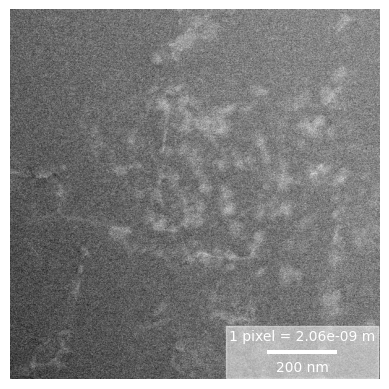

In [13]:
# get haadf from mic

# Get haadf
haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(
    exposure=haadf_exposure, resolution=haadf_resolution, folder_path=out_path
)

HAADF_tiff_to_png(out_path + haadf_tiff_name)
haadf = haadf_np_array

W, H = haadf.shape

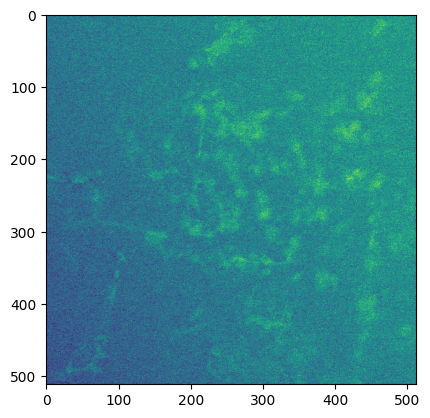

In [14]:
# best haadf after normalization
haadf_normalized = haadf_np_array

plt.imshow(haadf_normalized)

In [15]:
## get positons from sam

########SAM part ********************************************************************************************************
# -----> takes quite some time- 3 minutes-- to load --
from stemOrchestrator.MLlayer.MLlayerSAM import (
    setup_device,
    download_sam_model,
    initialize_sam_model,
    preprocess_image,
    generate_and_save_masks,
    create_normalized_particle_positions,
    display_image_with_masks,
    display_image_with_labels,
    extract_mask_contours,
    generate_mask_colors,
    visualize_masks_with_boundaries,
    extract_particle_data,
    print_boundary_points_info,
    plot_centroids,
    sample_particle_positions,
    plot_sampled_positions,
    create_visualization_with_masks,
)
import pickle
import numpy as np
from typing import List, Dict, Union


def run_sam(image_data: np.ndarray, path_folder: str) -> Union[List, Dict]:
    """Main function to run SAM segmentation pipeline."""
    device = setup_device()

    model_type = "vit_b"  # Options: 'vit_b', 'vit_l', 'vit_h'
    checkpoint_url = (
        "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
    )
    checkpoint_path = "sam_vit_b_01ec64.pth"
    download_sam_model(model_type, checkpoint_url, checkpoint_path)
    sam, mask_generator = initialize_sam_model(model_type, checkpoint_path, device)
    img_np = preprocess_image(image_data)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # Generate and visualize masks
    masks_path = f"{path_folder}/masks_Au_online.pkl"
    masks = generate_and_save_masks(mask_generator, img_np, masks_path)
    visual_image, centroids = create_visualization_with_masks(img_np, masks)
    display_image_with_masks(visual_image, "Image with Segmentation Masks")
    display_image_with_labels(
        visual_image, centroids, "Image with Segmentation Masks and Labels"
    )

    mask_contours = extract_mask_contours(masks)
    mask_colors = generate_mask_colors(len(masks))
    boundaries_path = (
        f"{path_folder}/Segmentation Masks with Boundaries and Centroids.png"
    )
    visualize_masks_with_boundaries(
        visual_image, centroids, mask_contours, mask_colors, boundaries_path
    )
    particles = extract_particle_data(masks)
    # Save particle data
    # with open(f'{path_folder}/particles.pkl', 'wb') as f:
    #     pickle.dump(particles, f)

    print_boundary_points_info(particles)
    centroids_array = np.array(centroids)
    plot_centroids(centroids_array, img_np)
    positions_sampled = sample_particle_positions(particles, img_np)
    plot_sampled_positions(positions_sampled, img_np, len(centroids))
    each_particle_position = create_normalized_particle_positions(
        particles, img_np.shape[:2]
    )
    # with open(f'{path_folder}/sampled_boundary_pts_particles.pkl', 'wb') as f: # Save normalized particle positions
    #     pickle.dump(each_particle_position, f)

    all_particle_keys = each_particle_position.keys()

    print("Processing complete!")
    return all_particle_keys, each_particle_position


##########****************************************************************************************************************************

20251114_121229
Using device: cpu
SAM model checkpoint already exists.


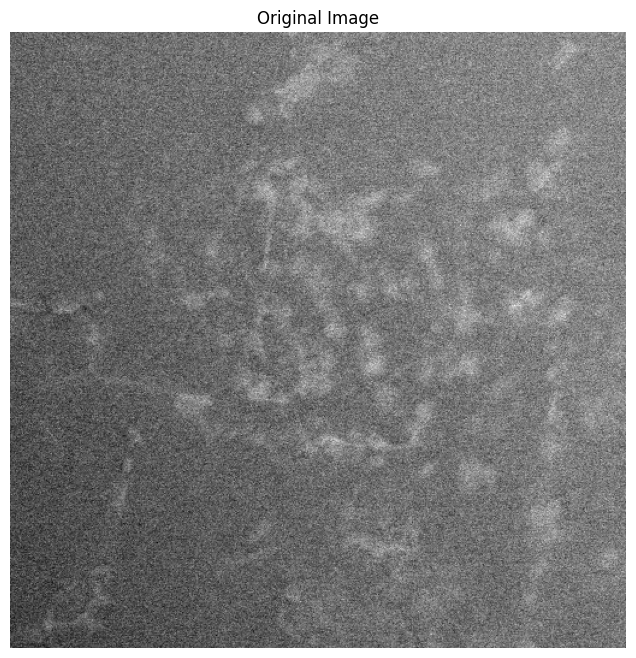

Generating masks...
Number of masks generated: 19
2025-11-14 12:12:45,442 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [13.5..233.08432].


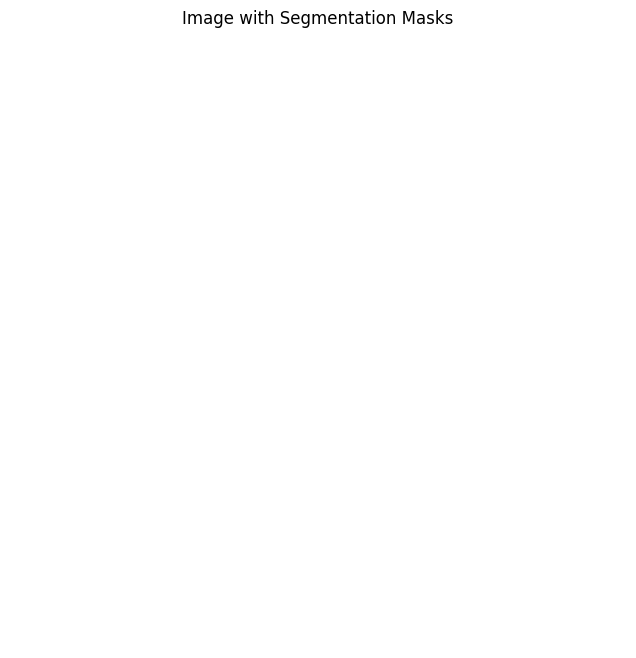

2025-11-14 12:12:45,468 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [13.5..233.08432].


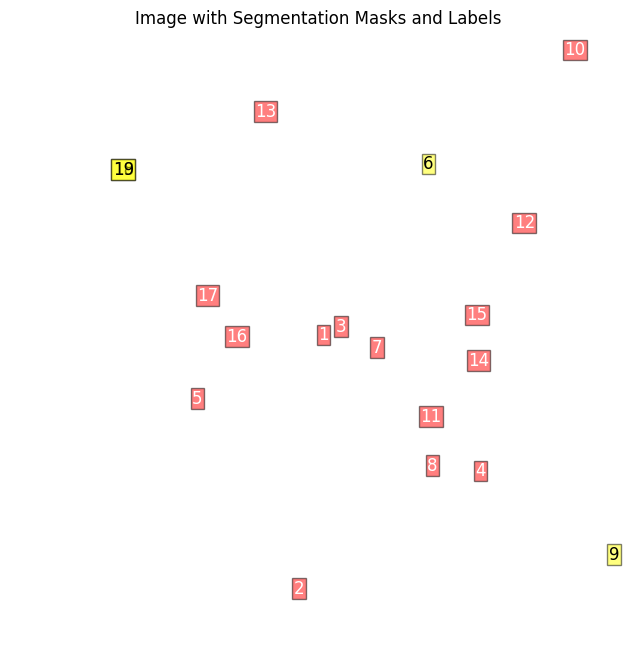

Extracted contours for 19 masks.
2025-11-14 12:12:45,510 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [13.5..233.08432].
Total particles stored: 19
Boundary Points per Particle:
-----------------------------
Particle 1: 4 boundary points
Particle 2: 12 boundary points
Particle 3: 11 boundary points
Particle 4: 13 boundary points
Particle 5: 13 boundary points
Particle 6: 14 boundary points
Particle 7: 12 boundary points
Particle 8: 13 boundary points
Particle 9: 15 boundary points
Particle 10: 12 boundary points
Particle 11: 12 boundary points
Particle 12: 14 boundary points
Particle 13: 15 boundary points
Particle 14: 11 boundary points
Particle 15: 10 boundary points
Particle 16: 14 boundary points
Particle 17: 11 boundary points
Particle 18: 19 boundary points
Particle 19: 13 boundary points
-----------------------------
Total boundary points across all particles: 238


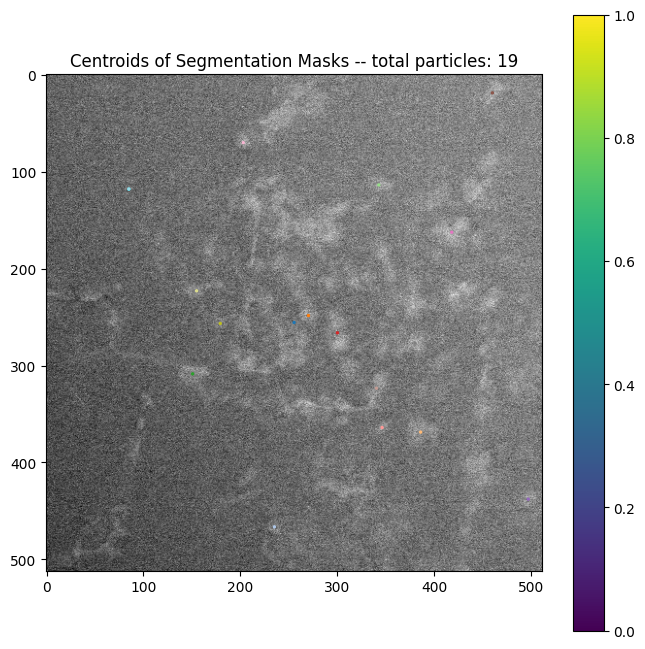

Positions array shape: (257, 3)


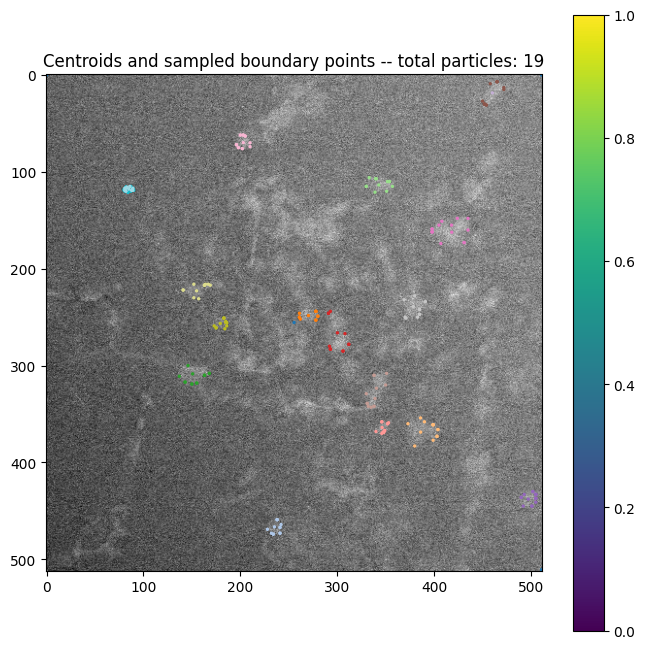

Processing complete!
20251114_121245


In [16]:
## run the segmentaiotn on haadf to get particles
from datetime import datetime

print(datetime.now().strftime("%Y%m%d_%H%M%S"))
all_particle_keys, each_particle_position = run_sam(
    haadf_np_array, out_path
)  ############ haadf normalized doesnt work here --- weird
print(datetime.now().strftime("%Y%m%d_%H%M%S"))

In [17]:
# finds positions to sample from
# N = 20
rng = np.random.default_rng(42)
# xs = rng.integers(0, W, size=N)
# ys = rng.integers(0, H, size=N)
# pixel_pos = np.stack([xs, ys], axis=1)

centroids = np.array([v["centroid"] for v in each_particle_position.values()])

# Sample N random centroids (without replacement if fewer than N)
N = len(centroids)
rng = np.random.default_rng(42)
idx = rng.choice(len(centroids), size=min(N, len(centroids)), replace=False)
sampled = centroids[idx]

# Separate xs and ys (keeping same data types as your original code)
xs = sampled[:, 0] * W
ys = sampled[:, 1] * H
pixel_pos = np.stack([xs, ys], axis=1)

print("xs:", xs)
print("ys:", ys)
print("pixel_pos:\n", pixel_pos)

np.save(f"{out_path}pixel_pos.npy", pixel_pos)

xs: [ 84.93023256 460.15974441 300.22451791 378.62676056 255.5
 235.17708333 418.24344569 386.14060258 380.18326693 154.86759582
 150.75560538 346.30075188 340.49033816 203.05113636 270.28703704
 342.94894895  84.92857143 497.18859649 179.29530201]
ys: [117.74418605  18.48881789 266.16115702 238.96244131 255.5
 466.44270833 162.31086142 368.65710187 276.89641434 222.79094077
 308.50224215 363.90977444 323.31884058  69.84090909 248.31944444
 113.4954955  117.89285714 437.8245614  256.4966443 ]
pixel_pos:
 [[ 84.93023256 117.74418605]
 [460.15974441  18.48881789]
 [300.22451791 266.16115702]
 [378.62676056 238.96244131]
 [255.5        255.5       ]
 [235.17708333 466.44270833]
 [418.24344569 162.31086142]
 [386.14060258 368.65710187]
 [380.18326693 276.89641434]
 [154.86759582 222.79094077]
 [150.75560538 308.50224215]
 [346.30075188 363.90977444]
 [340.49033816 323.31884058]
 [203.05113636  69.84090909]
 [270.28703704 248.31944444]
 [342.94894895 113.4954955 ]
 [ 84.92857143 117.8928571

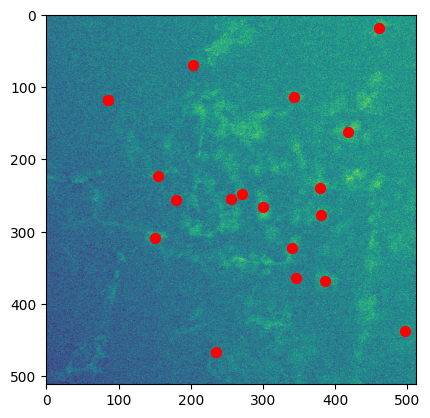

In [18]:
# plot position sampled
plt.imshow(haadf_normalized)
plt.scatter(xs, ys, s=50, c="r")
# want to save this? - nope

In [19]:
## setup edx acquire
import xmltodict
import json
from autoscript_tem_microscope_client.structures import EdsAcquisitionSettings
from autoscript_tem_microscope_client.enumerations import (
    EdsDetectorType,
    ExposureTimeType,
)


def get_channel_index(energy_keV: float, dispersion: float, offset: float) -> int:
    """Convert energy (keV) into spectrum channel index."""
    return int(round((energy_keV - offset) / dispersion))


def get_dispersion_and_offset(spectrum):
    """
    Extract dispersion and offset from EDS spectrum metadata (xml).
    Returns (dispersion_keV_per_ch, offset_keV).
    """
    xml_string = spectrum.metadata.metadata_as_xml
    metadata = xmltodict.parse(xml_string)
    metadata = json.loads(json.dumps(metadata))

    detectors = metadata["Metadata"]["Detectors"]["AnalyticalDetector"]

    # If only one detector, wrap it into a list
    if isinstance(detectors, dict):
        detectors = [detectors]

    # Take the first detector (or filter by name if needed)
    det = detectors[0]
    dispersion = float(det.get("Dispersion", 0))
    offset = float(det.get("OffsetEnergy", 0))

    return dispersion, offset


def configure_acquisition(exposure_time=2):
    """Configure the EDS acquisition settings."""
    # mic_server is global variable intriduced in def run function
    eds_detector_name = microscope.detectors.eds_detectors[0]
    eds_detector = microscope.detectors.get_eds_detector(eds_detector_name)
    # Configure the acquisition
    global eds_settings
    eds_settings = EdsAcquisitionSettings()
    eds_settings.eds_detector = eds_detector_name
    eds_settings.dispersion = eds_detector.dispersions[-1]  # 20 keV
    eds_settings.shaping_time = eds_detector.shaping_times[-1]
    eds_settings.exposure_time = exposure_time
    eds_settings.exposure_time_type = ExposureTimeType.LIVE_TIME
    return eds_settings

In [20]:
# get edx at those positon and stack them
# 2 minutes for 20 points
edx_exposure = 2  # in seconds
eds_settings = configure_acquisition(exposure_time=edx_exposure)

all_arrays = []  # 1. Create an empty list before the loop
for point in pixel_pos:
    # convert to fractional coordinates
    x_pos = point[0] / W
    y_pos = point[1] / H

    # position beam
    tf_acquisition.move_paused_beam(x_pos, y_pos)

    # Acquire the EDS spectrum
    microscope.optics.blanker.unblank()
    spectrum = microscope.analysis.eds.acquire_spectrum(eds_settings)
    microscope.optics.blanker.blank()

    # Average spectrum data from 4 detectors
    n_channels_per_detector = len(spectrum.data) // 4
    summed_spectrum = np.zeros(n_channels_per_detector)

    for i in range(4):
        start_idx = i * n_channels_per_detector
        end_idx = (i + 1) * n_channels_per_detector
        summed_spectrum += spectrum.data[start_idx:end_idx]

    # Use summed spectrum for analysis
    spectrum_data = summed_spectrum

    # stack the arrays
    all_arrays.append(spectrum_data)  # 2. Add the new array to the list

spectra = np.stack(all_arrays, axis=0)
print(spectra.shape)

2025-11-14 12:13:49,804 - INFO - Set beam position: old Point(x=0.5, y=0.5)
2025-11-14 12:13:49,834 - INFO - UPDATED beam position: NewPoint(x=0.16587935, y=0.22996911)
2025-11-14 12:13:53,064 - INFO - Set beam position: old Point(x=0.16587935, y=0.22996911)
2025-11-14 12:13:53,089 - INFO - UPDATED beam position: NewPoint(x=0.89874953, y=0.036110971)
2025-11-14 12:13:55,986 - INFO - Set beam position: old Point(x=0.89874953, y=0.036110971)
2025-11-14 12:13:56,015 - INFO - UPDATED beam position: NewPoint(x=0.58637601, y=0.51984602)
2025-11-14 12:13:58,931 - INFO - Set beam position: old Point(x=0.58637601, y=0.51984602)
2025-11-14 12:13:58,959 - INFO - UPDATED beam position: NewPoint(x=0.73950541, y=0.46672353)
2025-11-14 12:14:01,905 - INFO - Set beam position: old Point(x=0.73950541, y=0.46672353)
2025-11-14 12:14:01,937 - INFO - UPDATED beam position: NewPoint(x=0.49902344, y=0.49902344)
2025-11-14 12:14:04,853 - INFO - Set beam position: old Point(x=0.49902344, y=0.49902344)
2025-11

In [21]:
# normalize the spectra
# Optional: normalize spectra (safe min-max per spectrum)
mins = spectra.min(axis=1, keepdims=True)
ptps = np.ptp(spectra, axis=1, keepdims=True)
ptps = np.where(ptps == 0, 1.0, ptps)
spectra_norm = (spectra - mins) / ptps
np.save(f"{out_path}raw_spectra.npy", spectra)
# save raw spectra
np.save(f"{out_path}normalized_spectra.npy",spectra_norm)

In [22]:
# pca the data
# import libraries

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

k = 3
pca = PCA(n_components=k, random_state=42)
scores = pca.fit_transform(spectra_norm)  # shape (N, k)

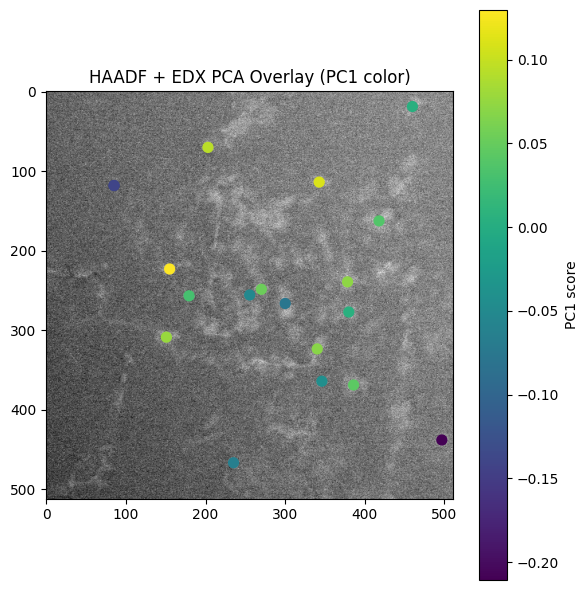

In [23]:
# imshow the pc1 values on the haadf
# -----------------------------
# 5) Plots
# -----------------------------

# a) HAADF overlay with PC1 color
plt.figure(figsize=(6, 6))
plt.imshow(haadf_normalized, cmap="gray")
plt.scatter(xs, ys, c=scores[:, 1], s=50)
plt.title("HAADF + EDX PCA Overlay (PC1 color)")
plt.colorbar(label="PC1 score", cmap="magma")
plt.tight_layout()
# plt.savefig("/mnt/data/overlay_plot.png", dpi=160)
plt.show()

In [ ]:
# imshow the pc1 values on the haadf
# -----------------------------
# 5) Plots
# -----------------------------

# a) HAADF overlay with PC1 color
plt.figure(figsize=(6, 6))
plt.imshow(haadf_normalized, cmap="gray")
plt.scatter(xs, ys, c=scores[:, 1], s=50)
plt.title("HAADF + EDX PCA Overlay (PC2 color)")
plt.colorbar(label="PC1 score", cmap="magma")
plt.tight_layout()
# plt.savefig("/mnt/data/overlay_plot.png", dpi=160)
plt.show()

In [ ]:
# KMeans on PCA scores
km = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_labels = km.fit_predict(scores)

In [ ]:
# b) PCA scatter with clusters
plt.figure(figsize=(6, 5))
plt.scatter(scores[:, 0], scores[:, 1], s=8, alpha=0.8, c=cluster_labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter of EDX Spectra with KMeans Clusters")
plt.tight_layout()
# plt.savefig("/mnt/data/pca_scatter.png", dpi=160)
plt.show()

## end